### Investigate whether regressing out potential confounders could alter data preprocessing 

After collecting the raw counts, try regressing out some factors. Follows this script: 0_dataset_formatting_invivo_counts.ipynb

Conclusion: regressing out the general covariates does not seem to lead to differences in conclusions. I will proceed with the version without regressing out. 

## QC

In [1]:
import scanpy as sc
import anndata as ad
import os
import datetime
import pandas as pd
import numpy as np
seed=1
import matplotlib.pyplot as plt
# from pybiomart import Dataset
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42

In [2]:
gene_list_1 = ['Olig2','Sox10','Olig1','Pdgfra','Cspg4','Myrf']
gene_list_2 = ['Olig2','Sox10','Pdgfra','Cspg4','Ascl1','Plp1','Opalin','Myrf','Mbp','Pou3f1','Mpz','Egr2','Prx','Pmp22']
gene_list_3 = ['Pou3f2','Src','Erbb3','Ntrk2','Itga1','Dag1','Ptn']
myelin_genes = ["Mag", "Plp1", "Pou3f1", "Egr2", "Prx", "Mpz", "Pmp22", "Ncmap"]
nerve_support = ["Plat", "Gap43", "Erbb3", "Gdnf", "Sostdc1", "Bdnf", "Fabp7"]
sc_genes = ["Mbp", "Ngfr", "Nfatc4", "Mpz", "Mog", "Gfap", "Ntf3", "Aqp4", "Tgfb1",
               "Pmp22", "Pou3f1", "Sox10"]
relevant_genes = gene_list_1+gene_list_2+gene_list_3+myelin_genes+nerve_support+sc_genes
relevant_genes = list(set(relevant_genes))

In [3]:
len(relevant_genes)

37

In [4]:
adata = sc.read_h5ad("dt_out/0_preprocessing/invivo_raw_counts_combined_fixed_varname_filtered_beforeQC.h5ad")

/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


quick filter based on mt and total counts and genes

In [5]:
adata.obs["outlier_mt"] = adata.obs.pct_counts_mt > 22
adata.obs["outlier_total"] = adata.obs.total_counts > 0.7*1e7
adata.obs["outlier_ngenes"] = adata.obs.n_genes_by_counts < 3000
adata.obs["outlier_ERCC"] = adata.obs.pct_counts_ERCC > 20

print(
    "%u cells with high %% of mitochondrial genes"
    % (sum(adata.obs["outlier_mt"]))
)
print("%u cells with large total counts" % (sum(adata.obs["outlier_total"])))
print("%u cells with large number of genes" % (sum(adata.obs["outlier_ngenes"])))
print("%u cells with high pct_counts_ERCC" % (sum(adata.obs["outlier_ERCC"])))

adata = adata[~adata.obs["outlier_mt"], :]
adata = adata[~adata.obs["outlier_total"], :]
adata = adata[~adata.obs["outlier_ngenes"], :]
adata = adata[~adata.obs["outlier_ERCC"], :]

19 cells with high % of mitochondrial genes
11 cells with large total counts
14 cells with large number of genes
9 cells with high pct_counts_ERCC


In [6]:
adata.write_h5ad("dt_out/0_preprocessing/invivo_raw_counts_combined_fixed_varname_filtered_postBasicQC.h5ad")

In [7]:
adata = sc.read_h5ad("dt_out/0_preprocessing/invivo_raw_counts_combined_fixed_varname_filtered_postBasicQC.h5ad")

/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Normalisation & HVG

In [8]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata, base=2)

In [9]:
adata.obs['Batch'] = adata.obs['Batch'].astype(str)
adata.obs['Animal'] = adata.obs['Animal'].astype(str)

In [10]:
adata.obs['Batch_Animal'] = adata.obs['Batch'] + adata.obs['Animal']

In [11]:
sc.pp.highly_variable_genes(adata, n_top_genes=3000, batch_key="Batch_Animal", subset=False)

In [12]:
np.sum(adata.var['highly_variable'])

3007

In [13]:
hvg_selected = list(adata.var['highly_variable'][adata.var['highly_variable']].index.values) + relevant_genes
hvg_selected = list(set(hvg_selected))
hvg_selected = [x for x in hvg_selected if x.startswith("ERCC")==False]
# 

In [14]:
adata.var['highly_variable_modified'] = adata.var['highly_variable'].index.isin(hvg_selected)

In [15]:
adata.var['highly_variable_original'] = adata.var['highly_variable']

In [16]:
adata.var['highly_variable'] = adata.var['highly_variable_modified']

In [17]:
adata.write_h5ad("dt_out/0_preprocessing/invivo_raw_counts_combined_fixed_varname_filtered_postBasicQC_preHVG.h5ad")

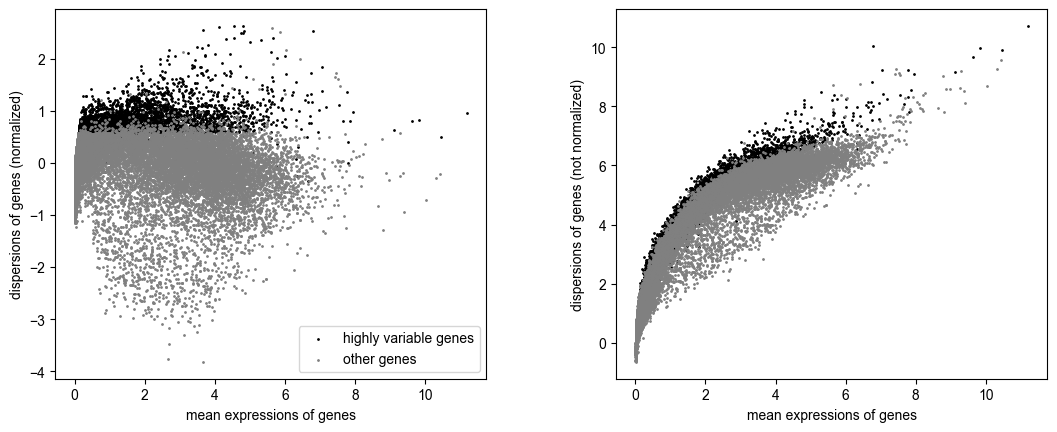

In [18]:
sc.pl.highly_variable_genes(adata)

In [19]:
np.sum(adata.var.highly_variable)

3000

In [20]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt","pct_counts_ERCC"],n_jobs=5)

In [21]:
#Ensure there is no negative value
# adata.X = adata.X + np.min(adata.X)*-1

In [22]:
sc.tl.pca(adata,use_highly_variable=True) 

/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


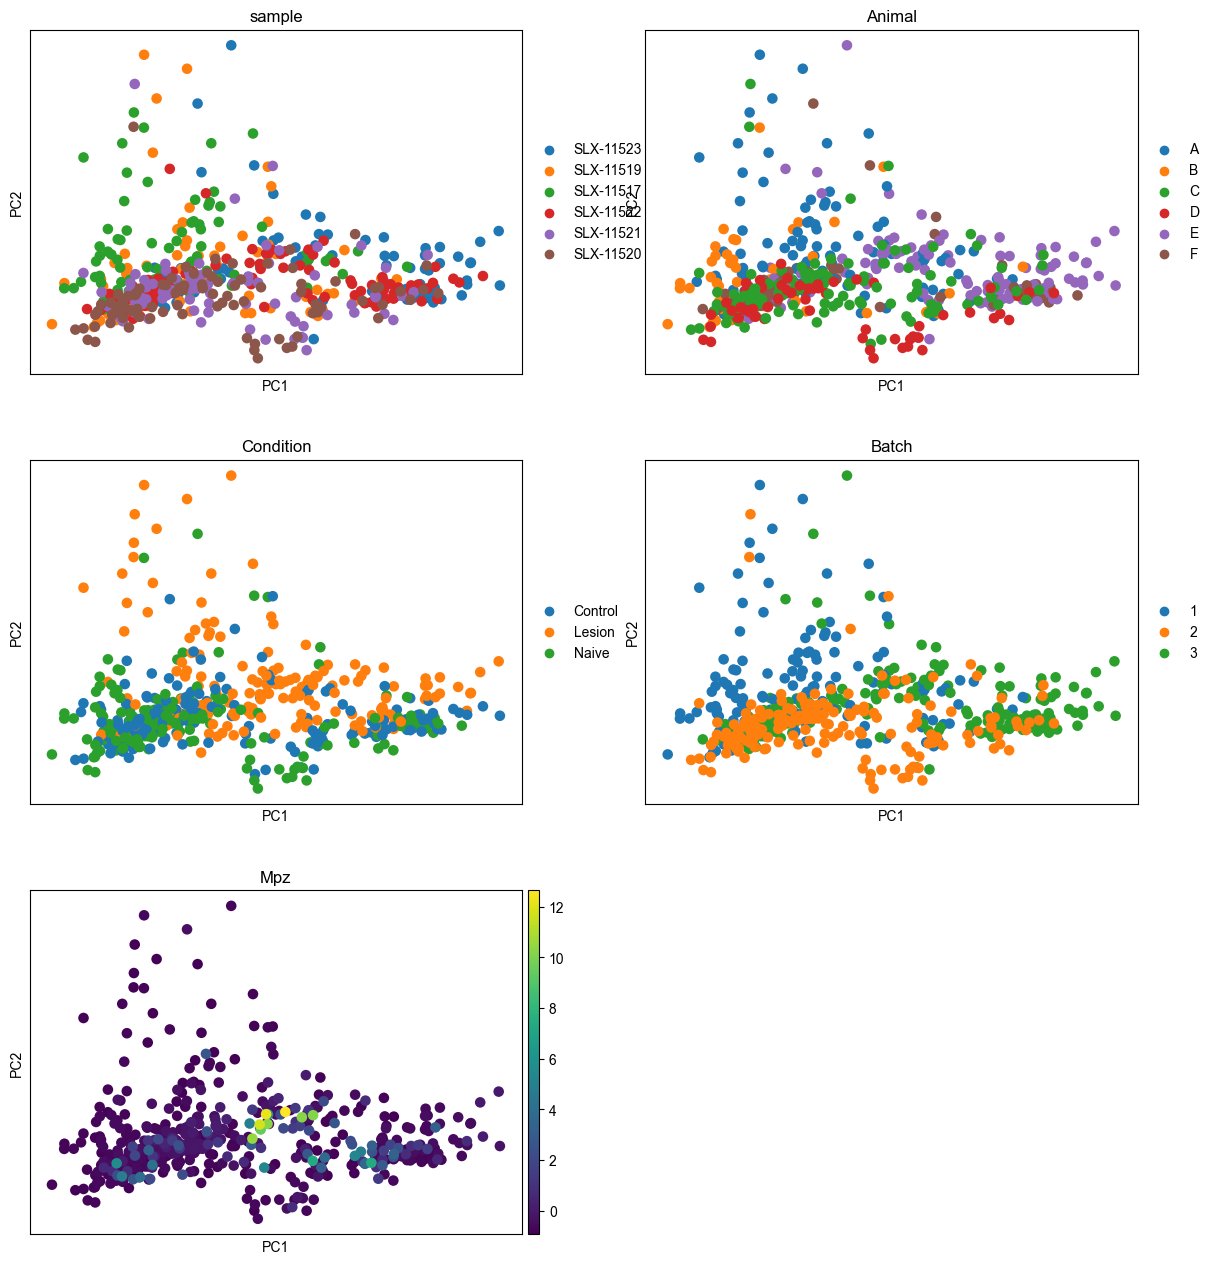

In [23]:
sc.pl.pca(
    adata,
    color=["sample", "Animal", "Condition", "Batch", "Mpz"],
    ncols=2,
)

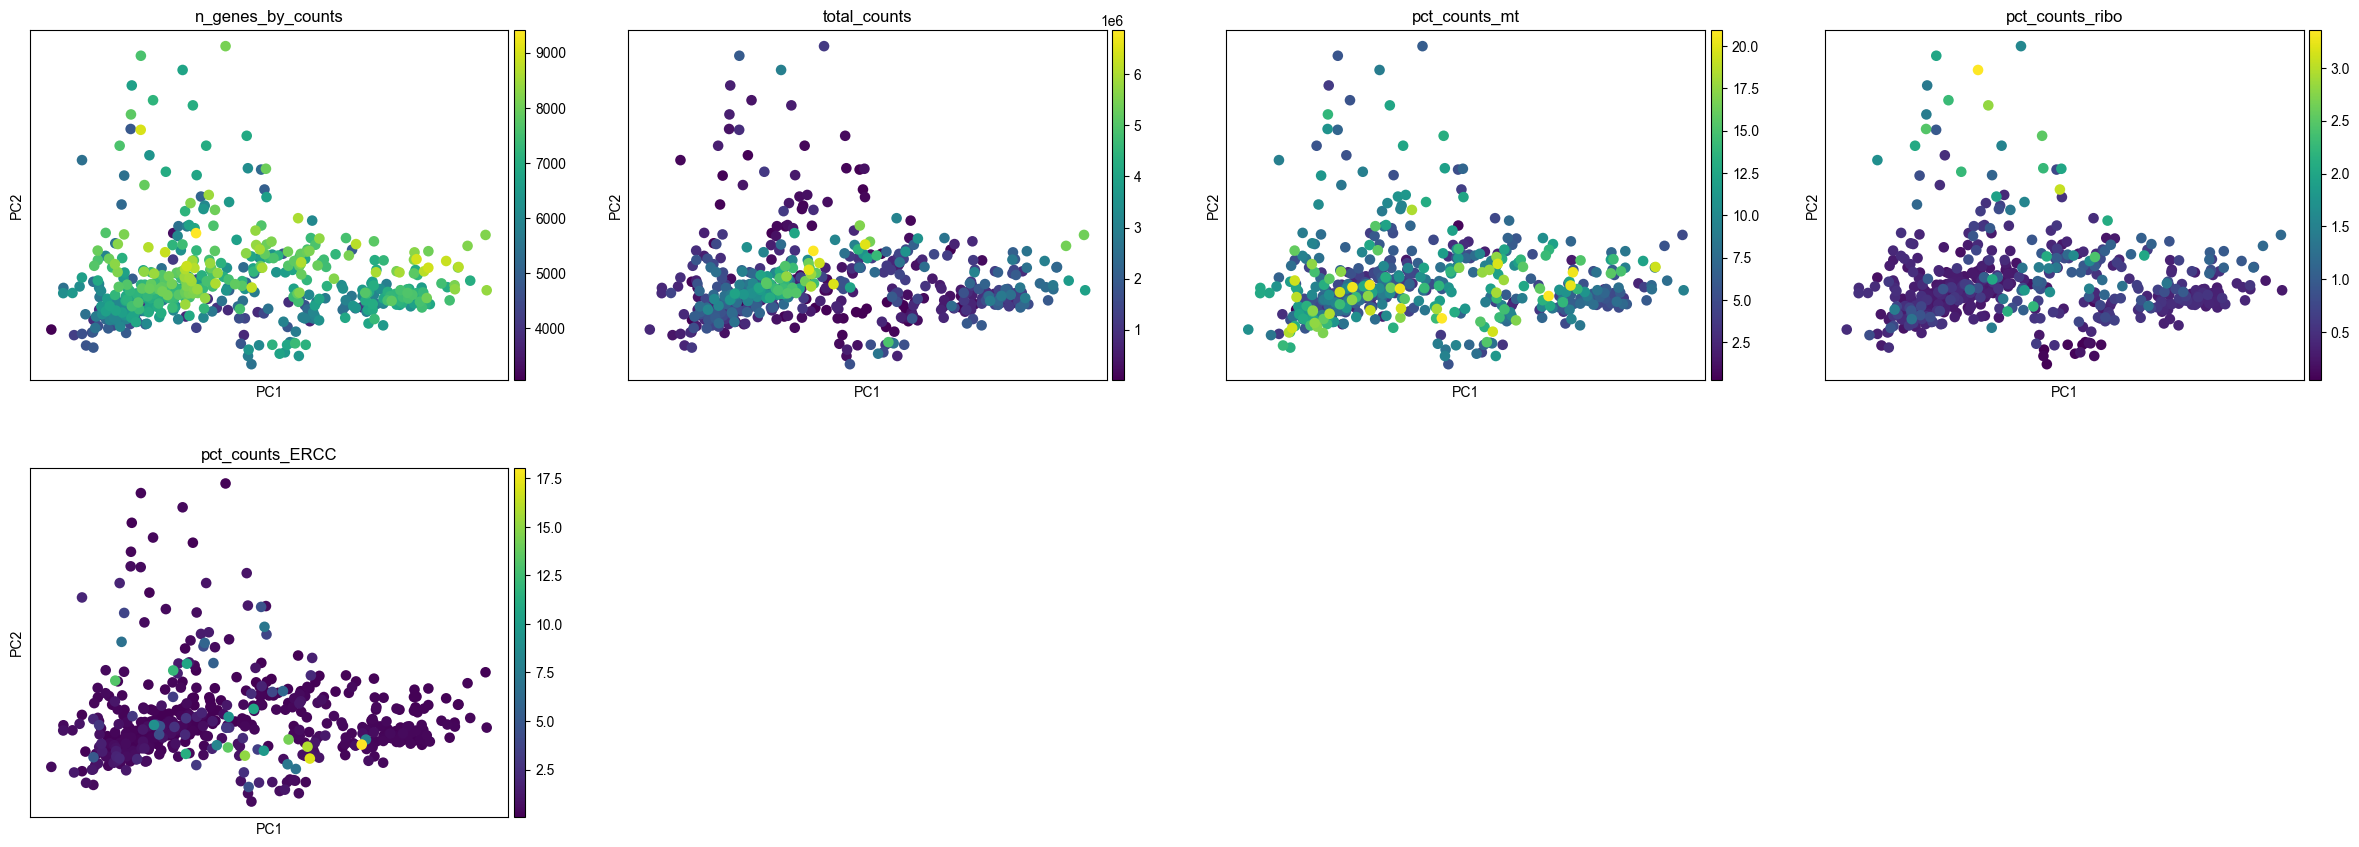

In [24]:
sc.pl.pca(adata, color = ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo',"pct_counts_ERCC"])

In [25]:
sc.pp.neighbors(adata, 50, random_state=seed)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [26]:
sc.tl.umap(adata,random_state=seed)

/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


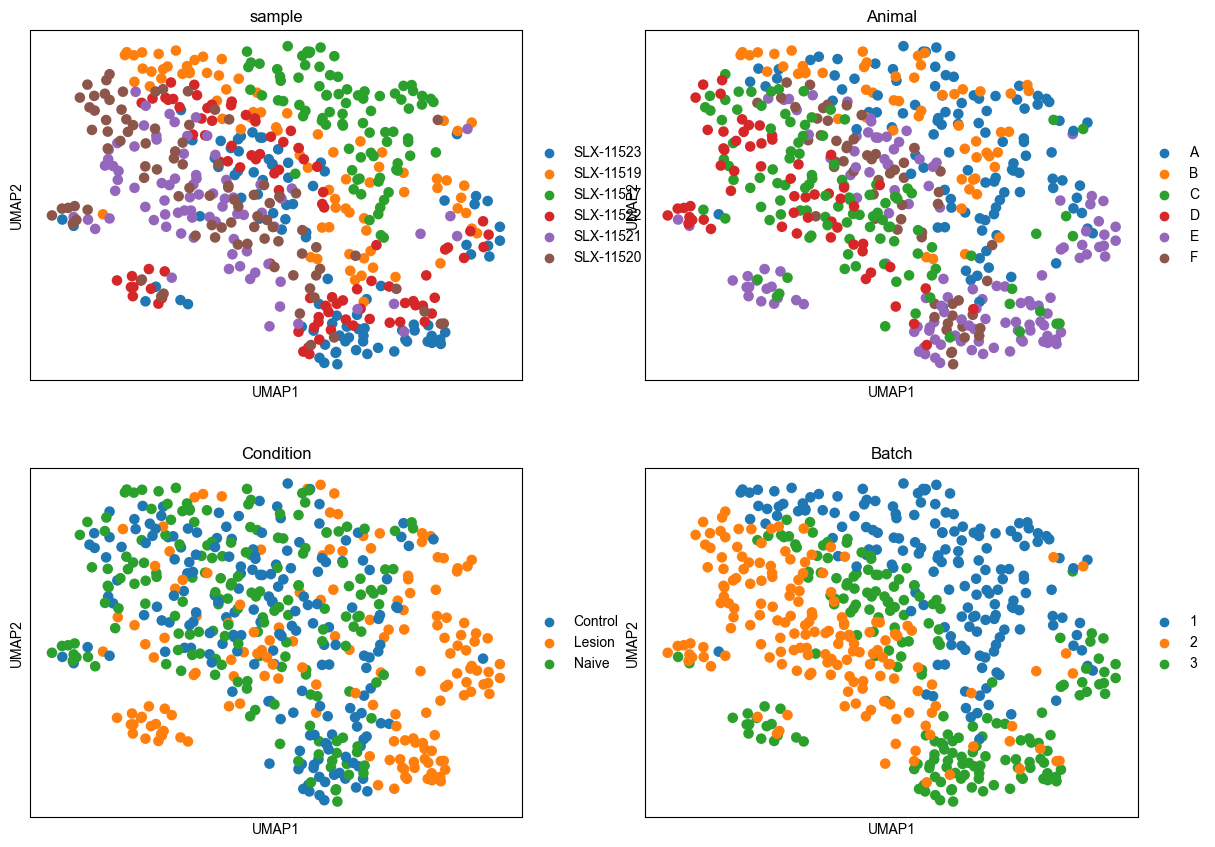

In [27]:
sc.pl.umap(
    adata,
    color=["sample", "Animal", "Condition", "Batch"],
    ncols=2,
)

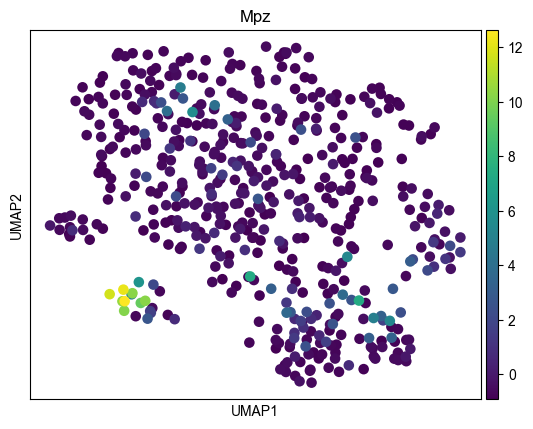

In [28]:
sc.pl.umap(
    adata,
    color=["Mpz"],
    ncols=2,
)

In [29]:
sc.tl.leiden(adata, n_iterations=2)

In [30]:
sc.tl.leiden(adata, resolution=0.5, key_added='leiden_0.5',n_iterations=2)

/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


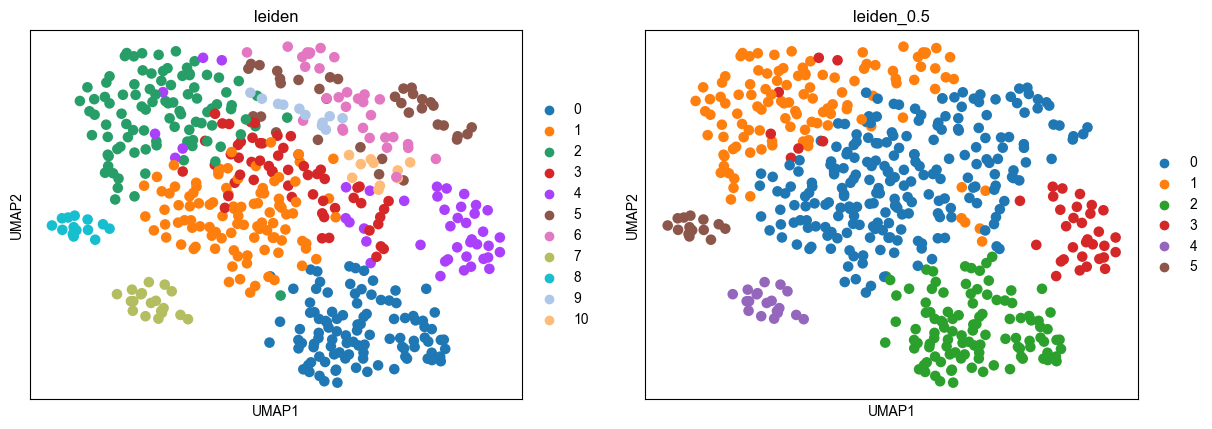

In [31]:
sc.pl.umap(adata, color=["leiden",'leiden_0.5'])

/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


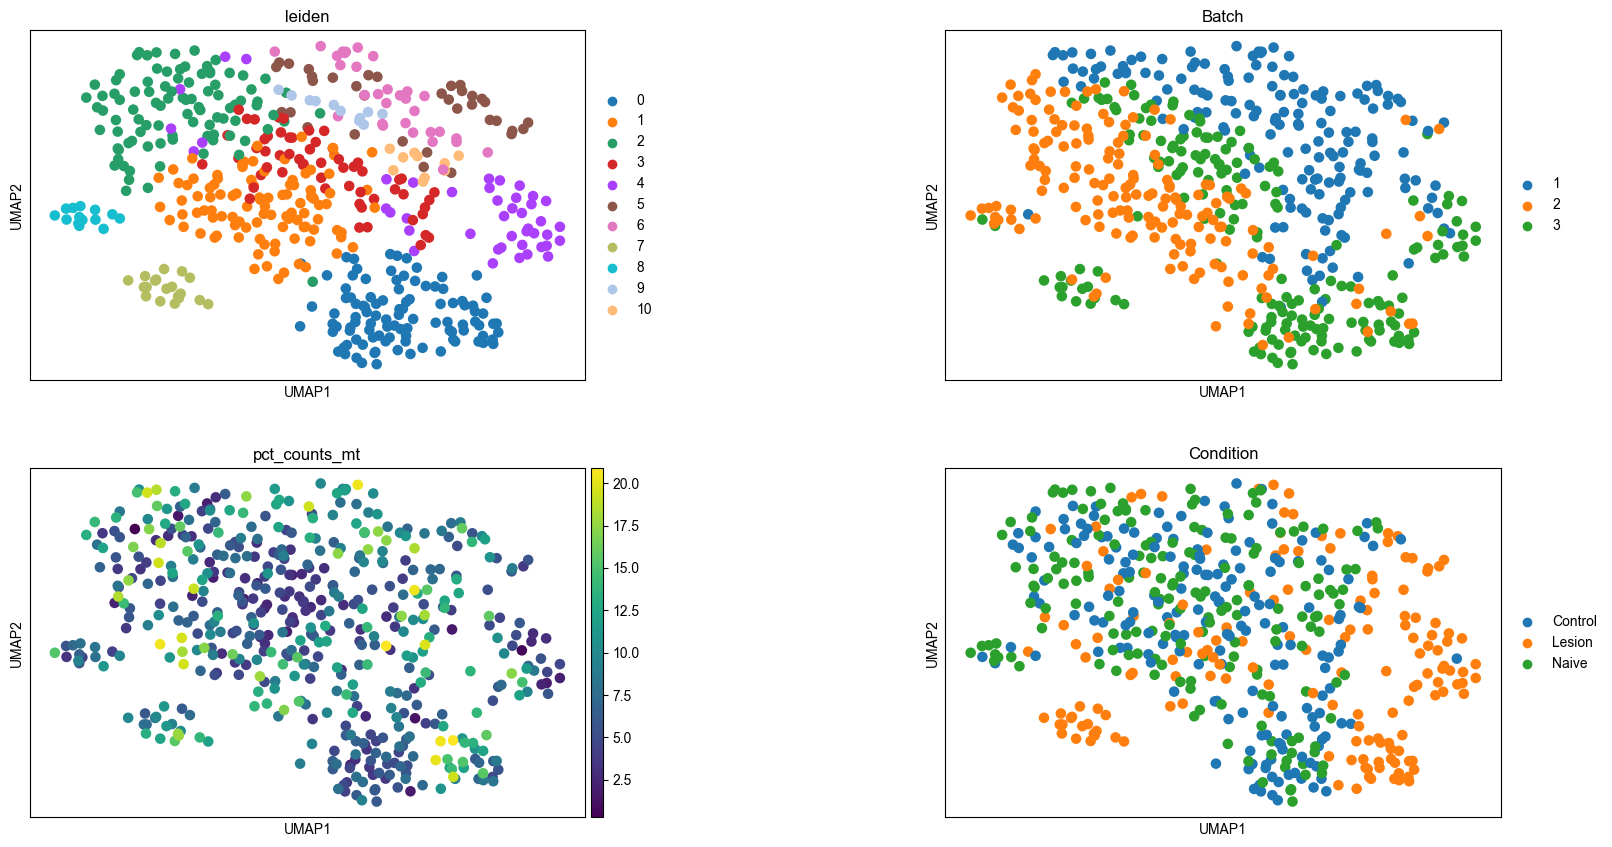

In [32]:
sc.pl.umap(
    adata,
    color=["leiden", "Batch", "pct_counts_mt", "Condition"],
    wspace=0.5,
    ncols=2,
)

In [33]:
adata.write_h5ad("dt_out/0_preprocessing/invivo_raw_counts_combined_fixed_varname_filtered_afterQC_umap_v2_with_regressedout.h5ad")

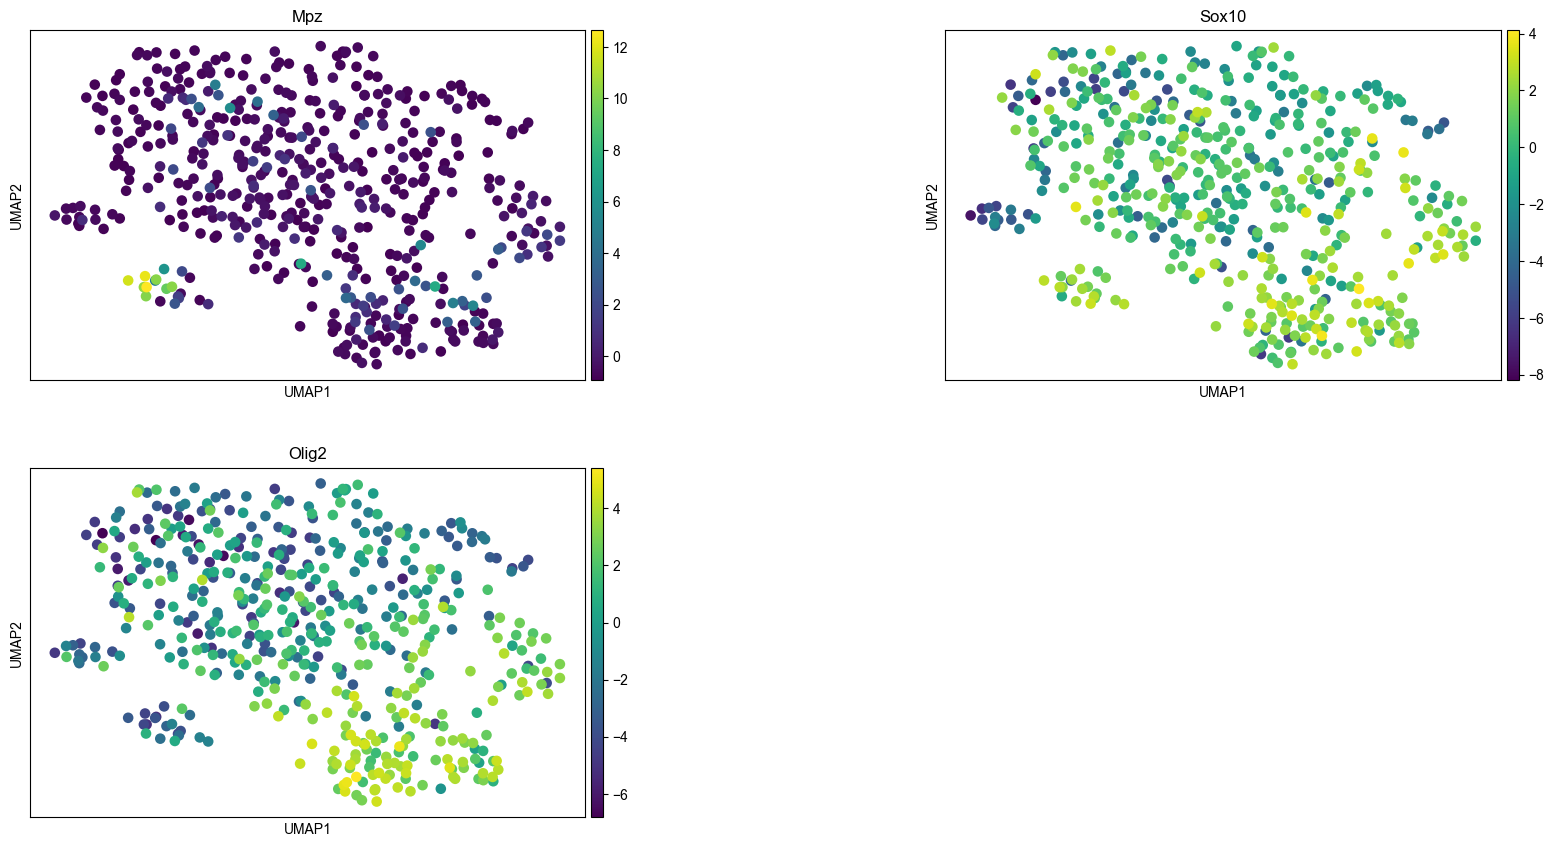

In [34]:
sc.pl.umap(
    adata,
    color=["Mpz",'Sox10','Olig2'],
    wspace=0.5,
    ncols=2,
)

In [35]:
sc.tl.leiden(adata, resolution=0.1, key_added='leiden_0.1',n_iterations=3)

In [36]:
sc.tl.leiden(adata, resolution=0.15, key_added='leiden_0.15',n_iterations=3)

In [37]:
sc.tl.leiden(adata, resolution=0.2, key_added='leiden_0.2',n_iterations=3)

In [38]:
sc.tl.leiden(adata, resolution=0.3, key_added='leiden_0.3',n_iterations=3)

In [39]:
sc.tl.leiden(adata, resolution=0.4, key_added='leiden_0.4',n_iterations=3)

In [42]:
adata.var

gene_symbol   gene_name             type  \
gene_name                                                     
Arsj        ENSRNOG00000000001        Arsj  Gene Expression   
Gad1        ENSRNOG00000000007        Gad1  Gene Expression   
Cbln1       ENSRNOG00000000010       Cbln1  Gene Expression   
Tcf15       ENSRNOG00000000012       Tcf15  Gene Expression   
Steap1      ENSRNOG00000000017      Steap1  Gene Expression   
...                        ...         ...              ...   
ERCC-00162                 NaN  ERCC-00162              NaN   
ERCC-00163                 NaN  ERCC-00163              NaN   
ERCC-00165                 NaN  ERCC-00165              NaN   
ERCC-00170                 NaN  ERCC-00170              NaN   
ERCC-00171                 NaN  ERCC-00171              NaN   

           gene_symbol_with_control     mt   ribo   ERCC  n_cells_by_counts  \
gene_name                                                                     
Arsj             ENSRNOG00000000001  False  False  False                 29   
Gad1             ENSRNOG00000000007  False  False  False                 16   
Cbln1            ENSRNOG00000000010  False  False  False                 15   
Tcf15            ENSRNOG00000000012  False  False  False                  8   
Steap1           ENSRNOG00000000017  False  False  False                 13   
...                             ...    ...    ...    ...                ...   
ERCC-00162               ERCC-00162  False  False   True                 54   
ERCC-00163               ERCC-00163  False  False   True                 23   
ERCC-00165               ERCC-00165  False  False   True                 31   
ERCC-00170               ERCC-00170  False  False   True                  8   
ERCC-00171               ERCC-00171  False  False   True                505   

            mean_counts  pct_dropout_by_counts  total_counts  n_cells  \
gene_name                                                               
Arsj           2.477113              94.894366        1407.0       29   
Gad1           0.029930              97.183099          17.0       16   
Cbln1          1.239437              97.359155         704.0       15   
Tcf15          0.021127              98.591549          12.0        8   
Steap1         0.878521              97.711268         499.0       13   
...                 ...                    ...           ...      ...   
ERCC-00162     4.146127              90.492958        2355.0       54   
ERCC-00163     0.338028              95.950704         192.0       23   
ERCC-00165     3.649648              94.542254        2073.0       31   
ERCC-00170     0.547535              98.591549         311.0        8   
ERCC-00171    80.102112              11.091549       45498.0      505   

            highly_variable     means  dispersions  dispersions_norm  \
gene_name                                                              
Arsj                  False  0.888820     3.175555          0.427470   
Gad1                  False  0.196786     1.542631          0.322993   
Cbln1                  True  0.621525     2.368965          0.449033   
Tcf15                 False  0.054413     0.354737         -0.605348   
Steap1                False  0.400089     1.871175          0.297288   
...                     ...       ...          ...               ...   
ERCC-00162            False  1.482031     3.854193          0.415968   
ERCC-00163            False  0.194360     1.479363          0.275842   
ERCC-00165            False  0.978743     3.020990          0.340308   
ERCC-00170            False  0.420748     1.845492          0.214822   
ERCC-00171            False  5.271231     7.313677          1.417613   

            highly_variable_nbatches  highly_variable_intersection  \
gene_name                                                            
Arsj                               2                         False   
Gad1                               2                         False   
Cbln

In [43]:
adata.var_names = adata.var['gene_name'].astype(str)
adata.var_names_make_unique()

/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


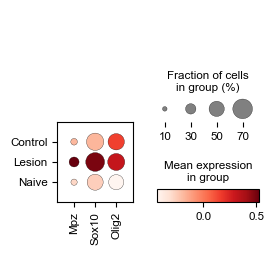

In [44]:
sc.pl.dotplot(adata, ["Mpz",'Sox10','Olig2'], groupby='Condition')

/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


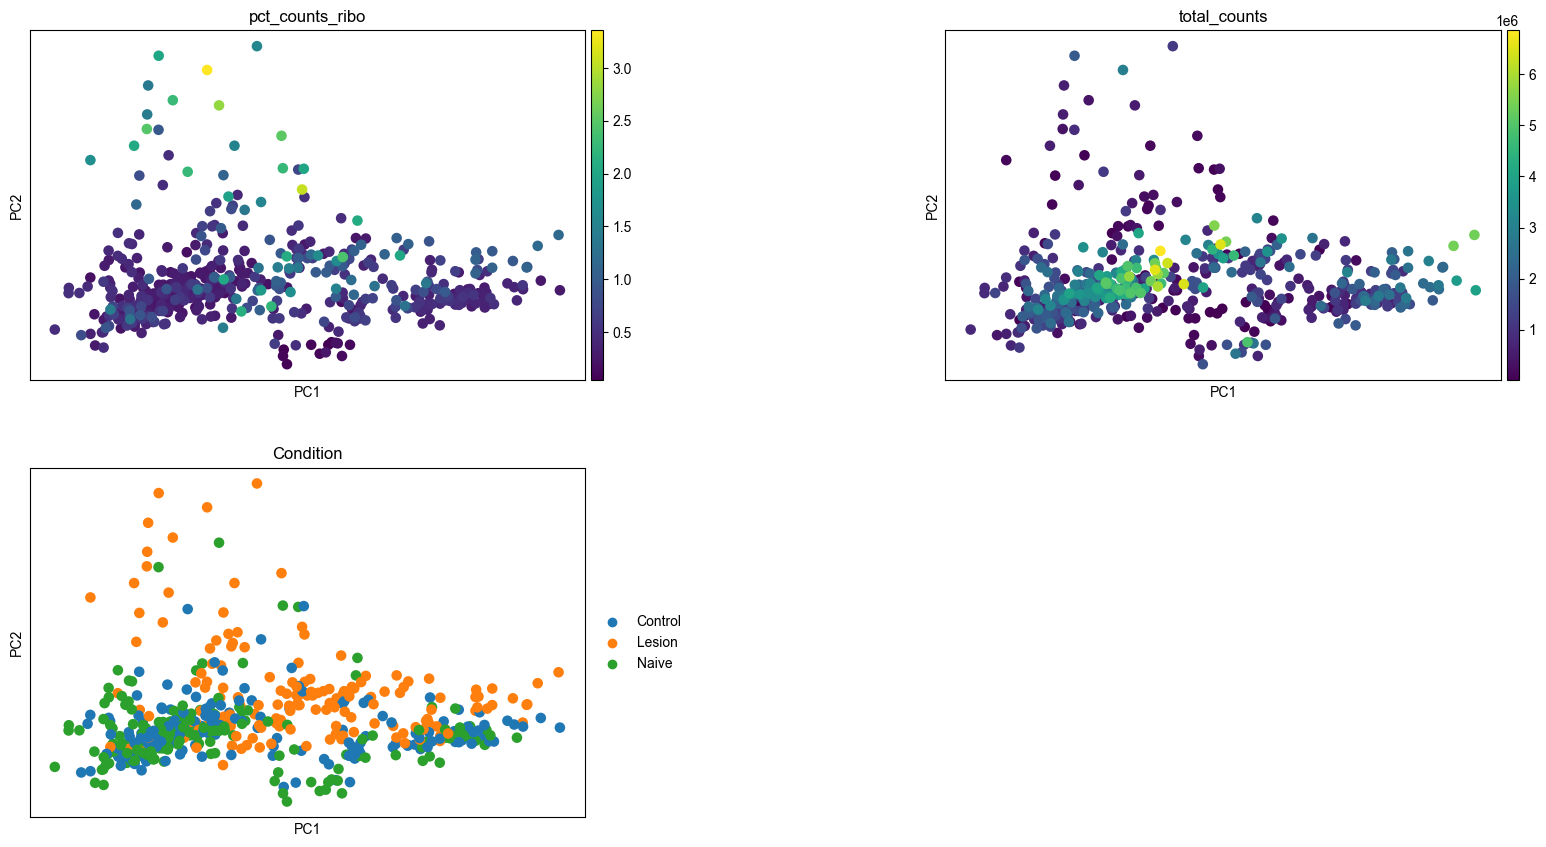

In [45]:
sc.pl.pca(
    adata,
    color=["pct_counts_ribo","total_counts","Condition"],
    wspace=0.5,
    ncols=2,
)

/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 

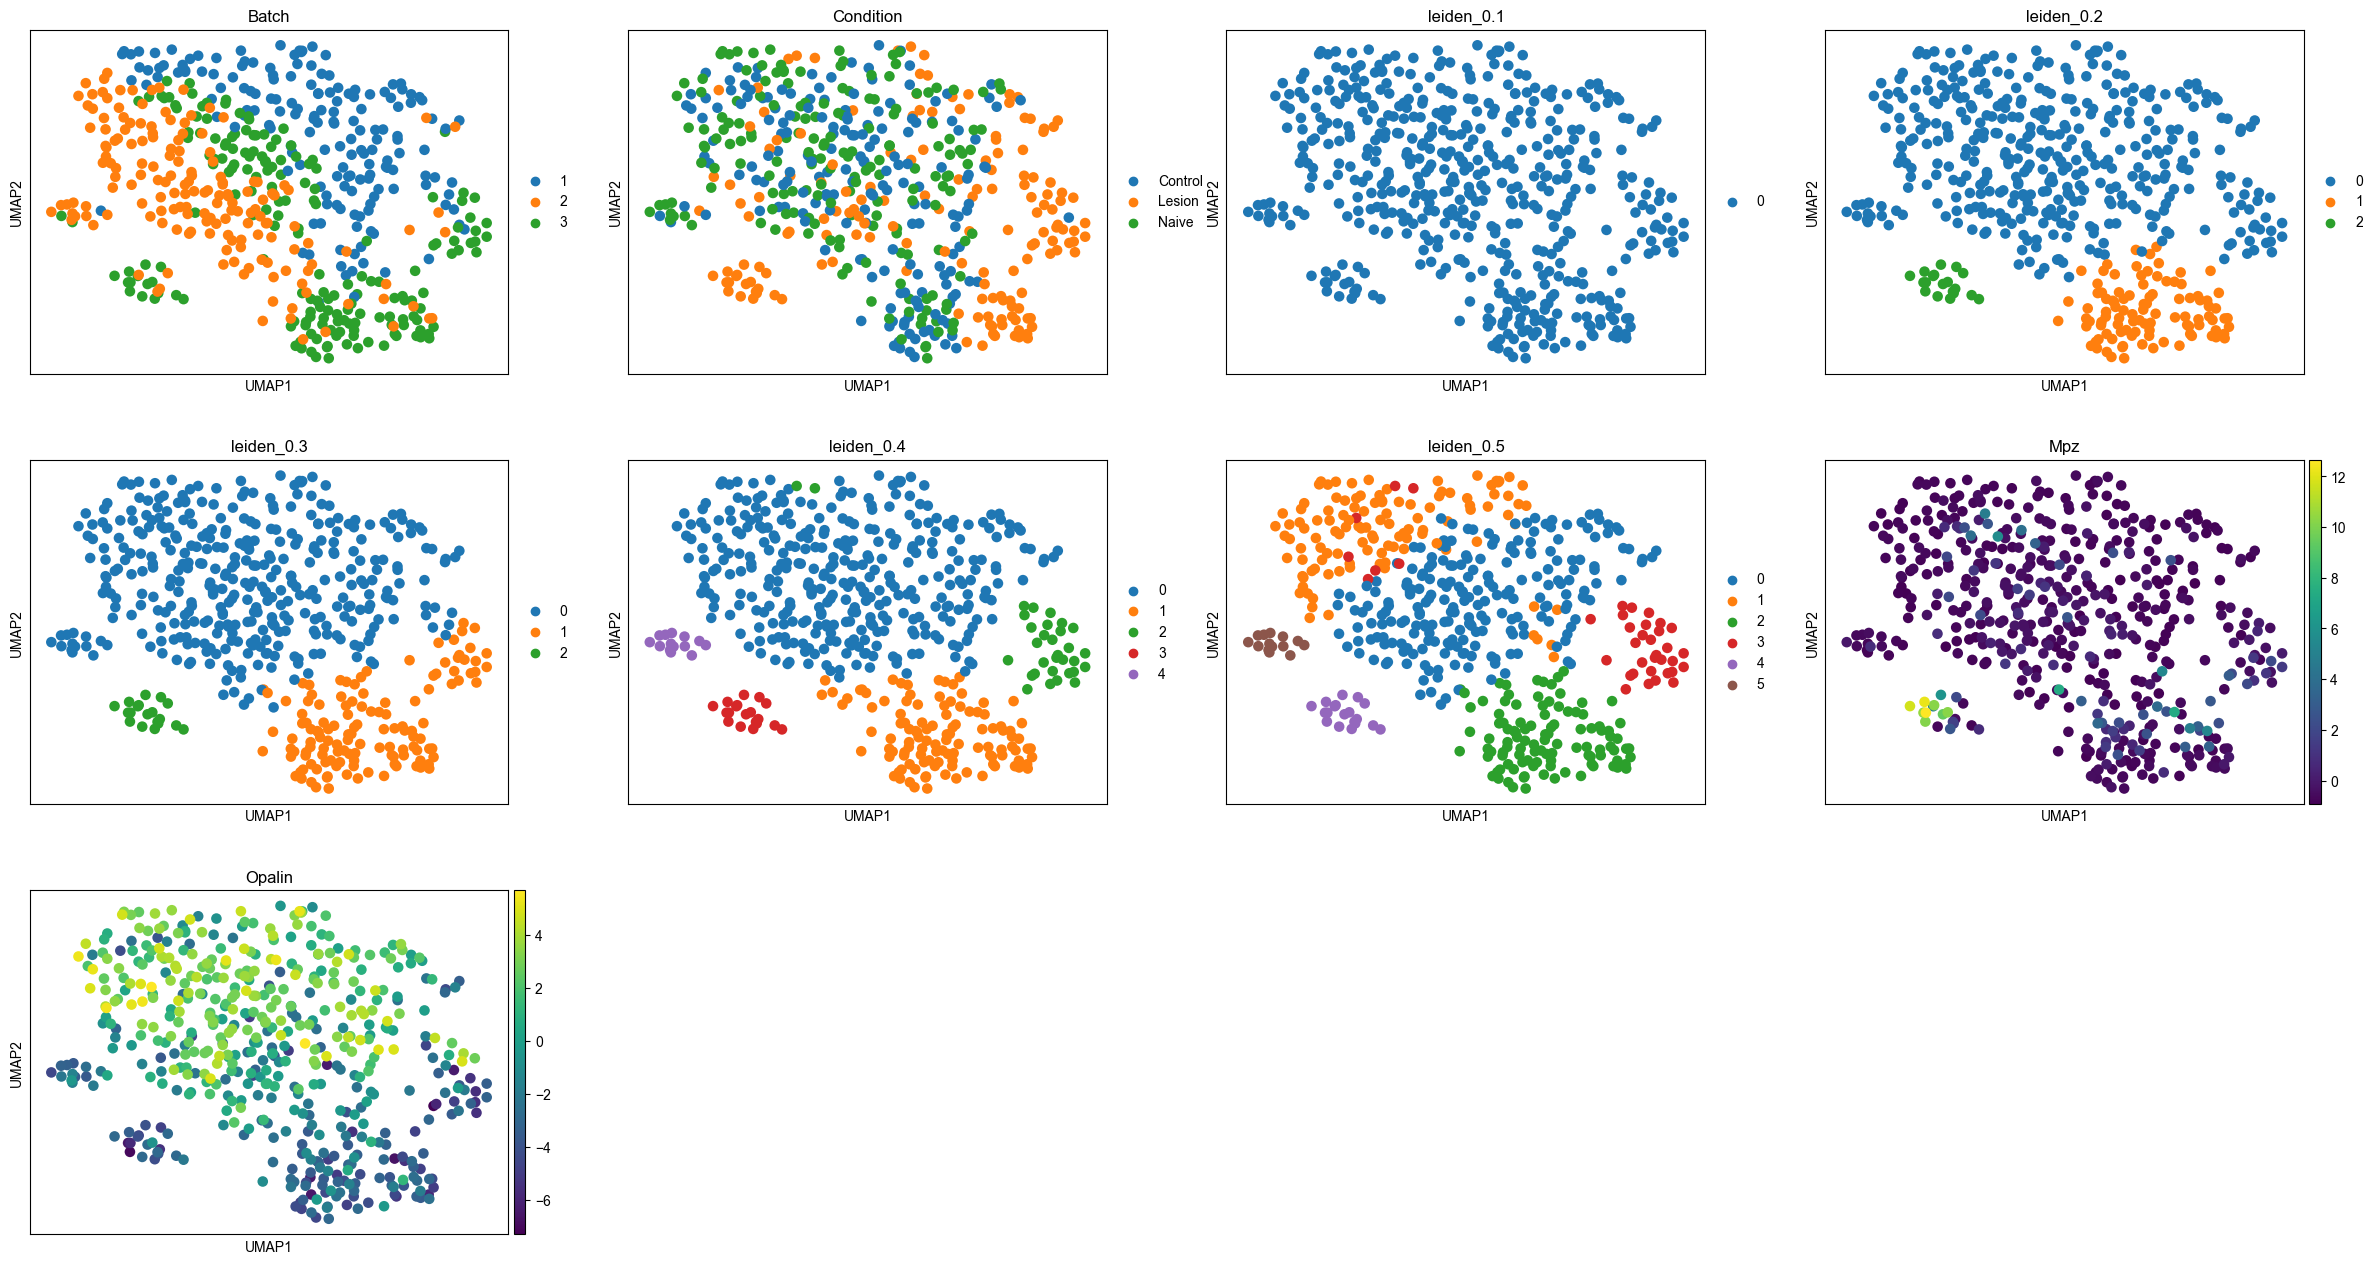

In [46]:
sc.pl.umap(adata, color=["Batch", "Condition","leiden_0.1",'leiden_0.2','leiden_0.3','leiden_0.4','leiden_0.5','Mpz',"Opalin"])

/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


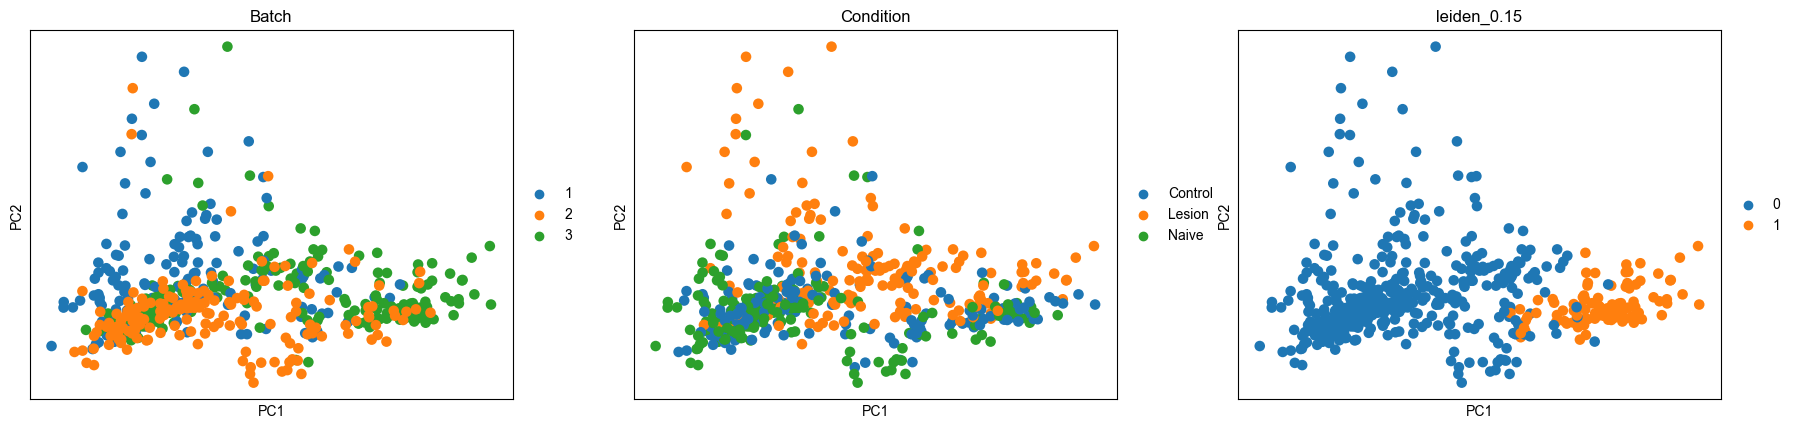

In [47]:
sc.pl.pca(adata, color=["Batch", "Condition","leiden_0.15"])

/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


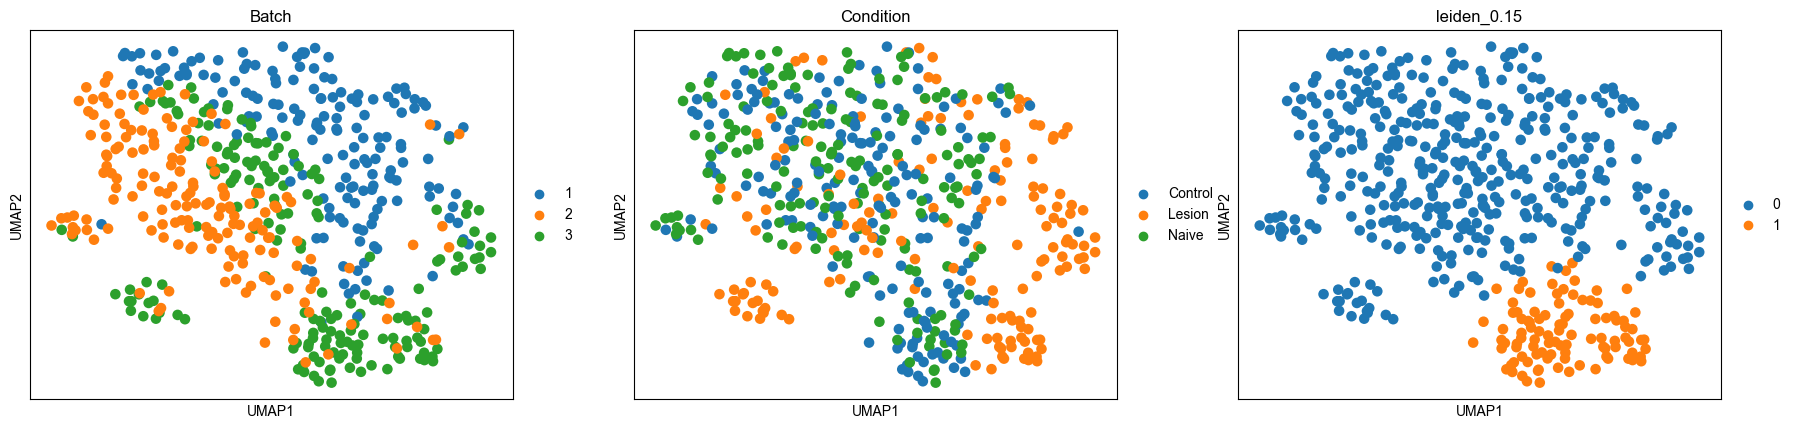

In [48]:
sc.pl.umap(adata, color=["Batch", "Condition","leiden_0.15"])

In [49]:
adata.write_h5ad("dt_out/0_preprocessing/invivo_combined_post_manual_qc_hvg_norm_log1p_leiden_with_regressed_out.h5ad")

In [50]:
adata = sc.read_h5ad("dt_out/0_preprocessing/invivo_combined_post_manual_qc_hvg_norm_log1p_leiden_with_regressed_out.h5ad")

/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 

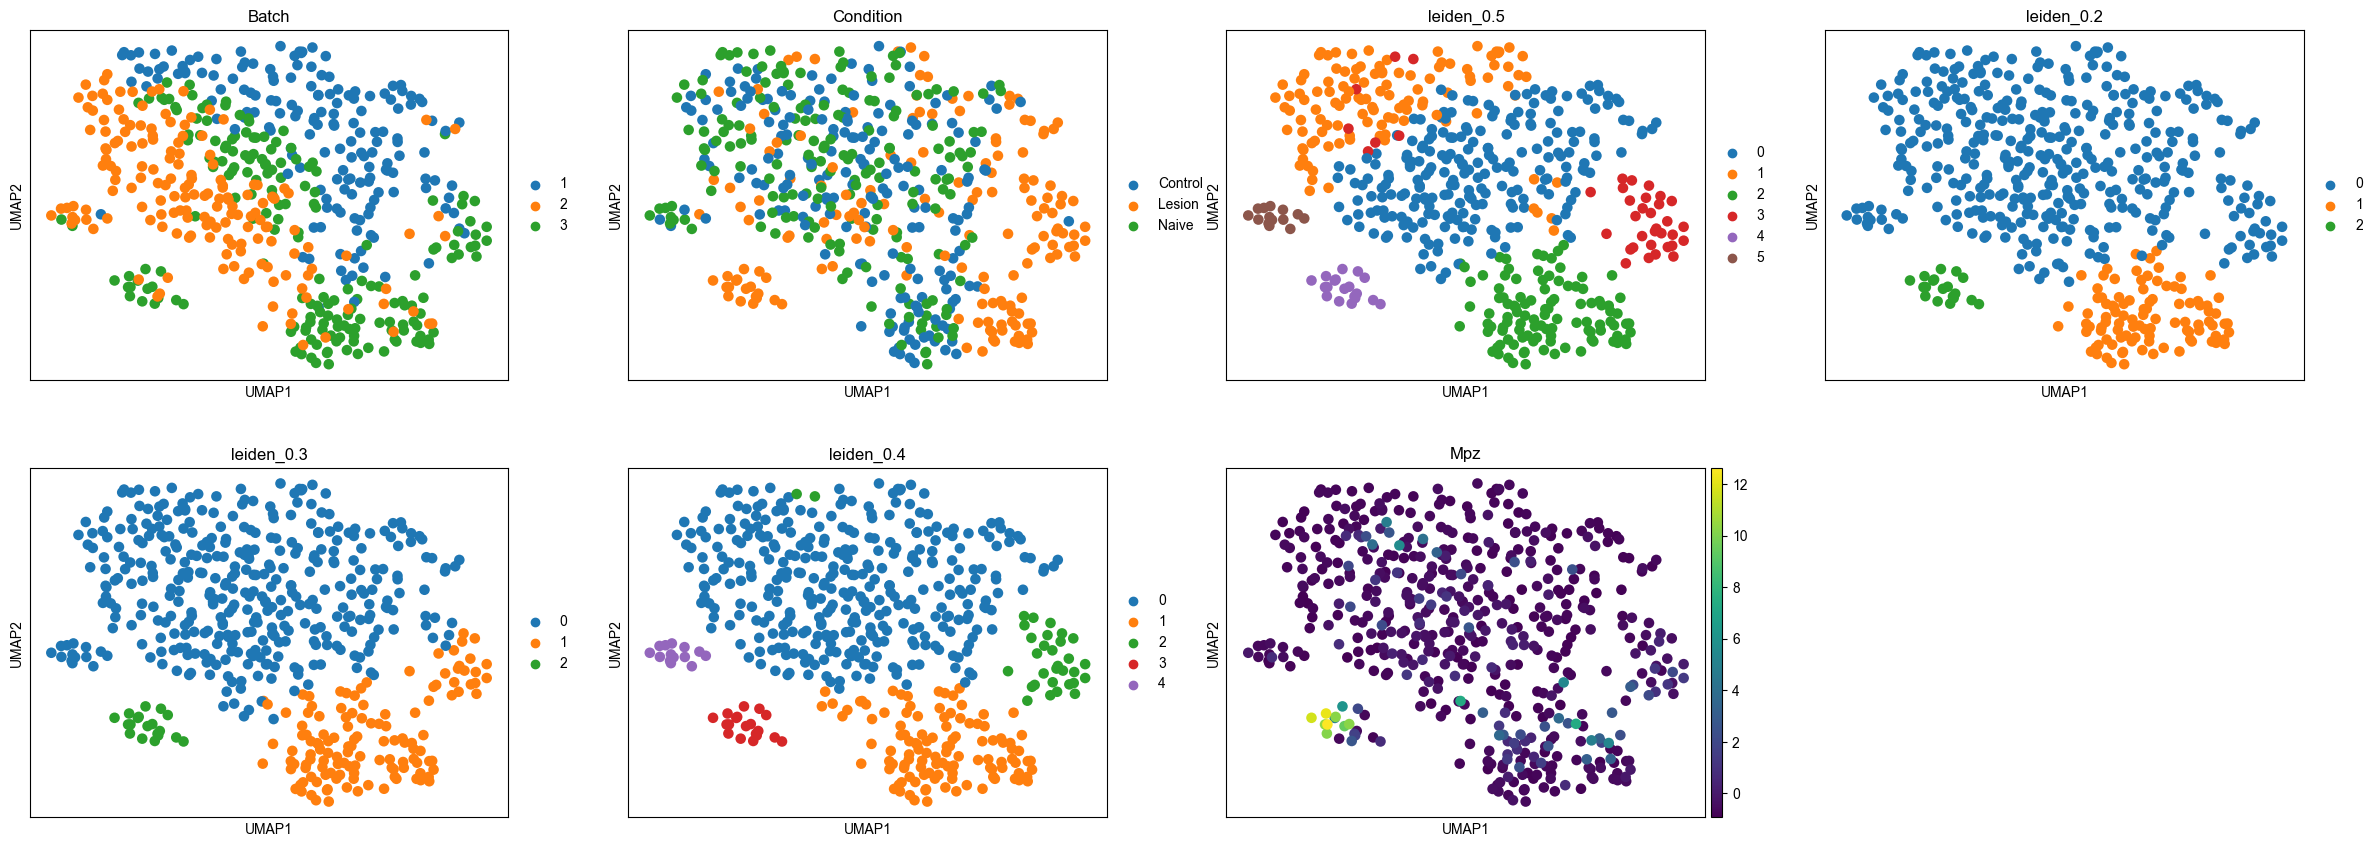

In [51]:
sc.pl.umap(adata, color=["Batch", "Condition","leiden_0.5",'leiden_0.2','leiden_0.3','leiden_0.4','Mpz'])

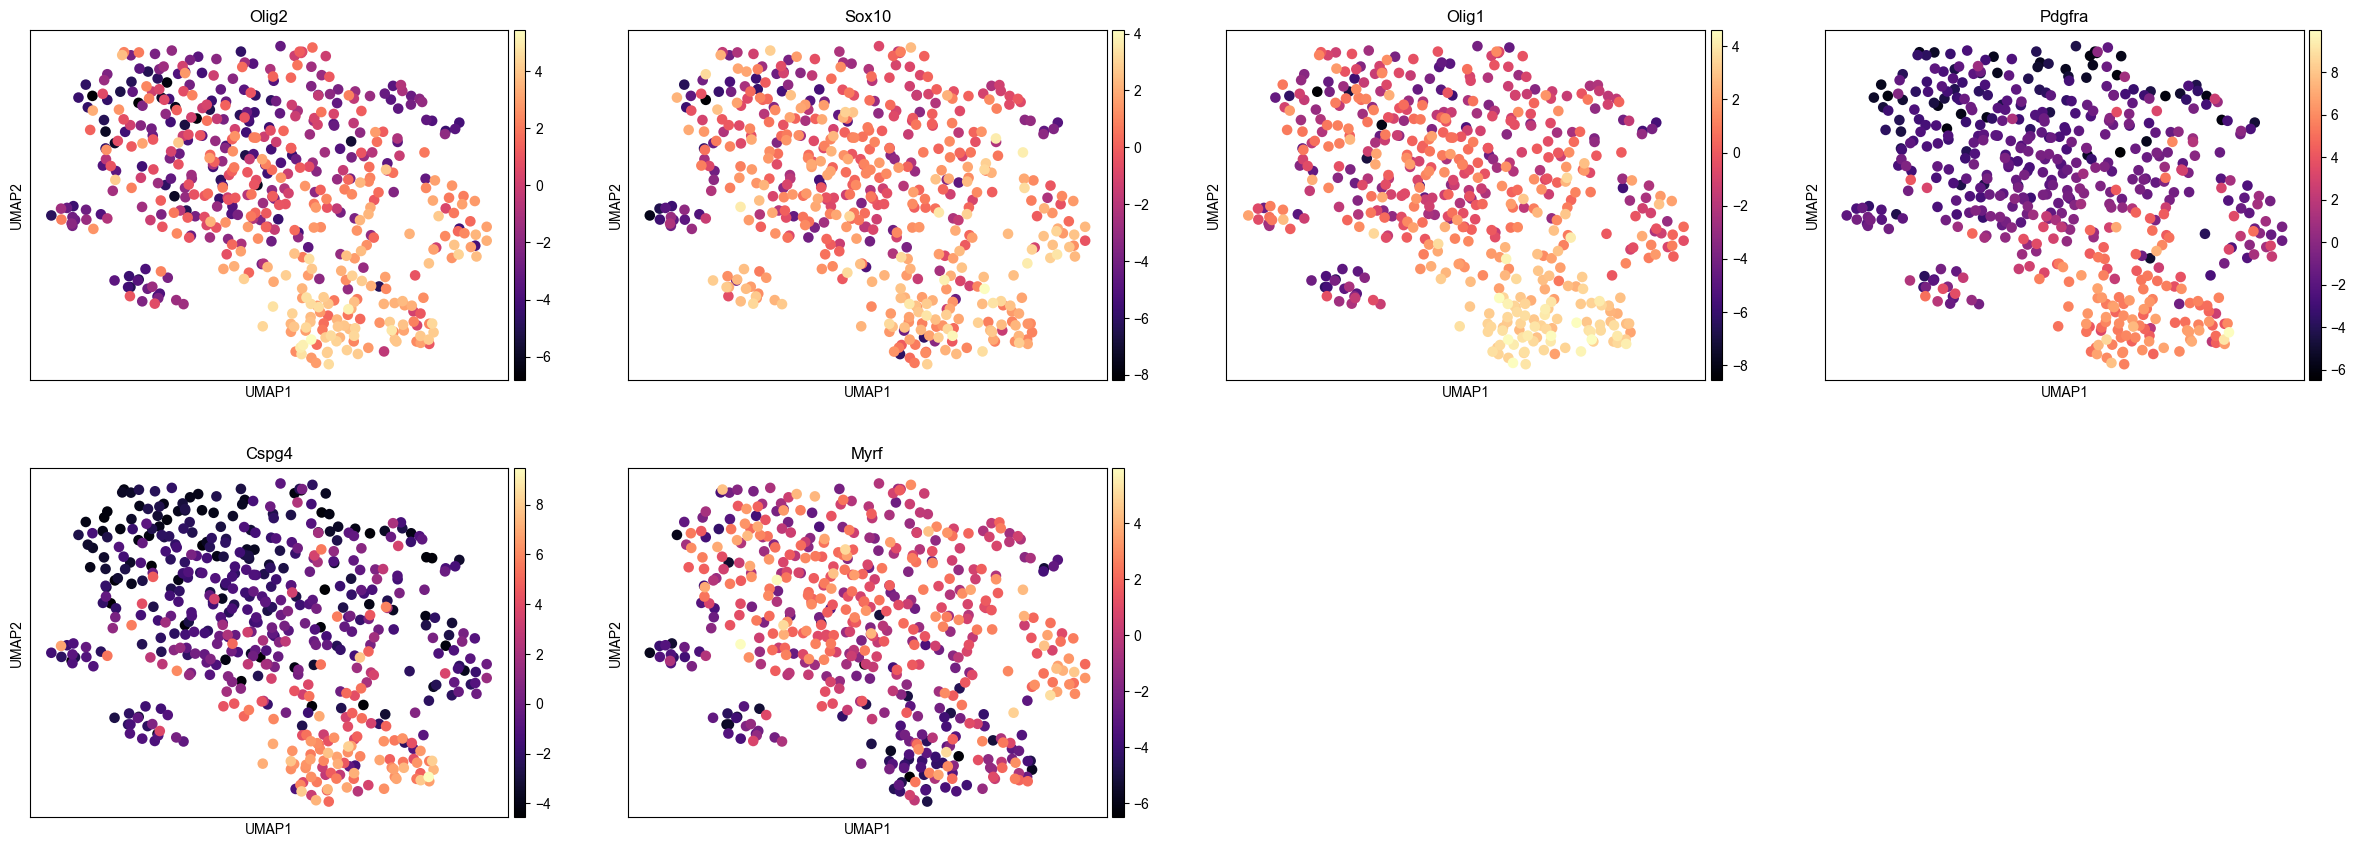

In [52]:
sc.pl.umap(adata, color=gene_list_1,cmap = "magma", save = "umap_markers_invivo_v2.pdf")

In [53]:
gene_list_3 = ['Pou3f1','Src','Erbb3','Ntrk2','Itga1','Dag1','Ptn']

In [54]:
myelin_genes = ["Mag", "Plp1", "Pou3f1", "Egr2", "Prx", "Mpz", "Pmp22"]
nerve_support = ["Plat", "Gap43", "Erbb3", "Sostdc1", "Bdnf", "Fabp7"]
sc_genes = ["Mbp", "Ngfr", "Nfatc4", "Mpz", "Mog", "Gfap", "Aqp4", "Tgfb1",
               "Pmp22", "Pou3f1", "Sox10"]